###### Required modules
The notebook should be run on jupyter notebook.
Running the notebook on google colab lead to some conflicts in represantation of the text and the import of modules

In [1]:
!pip install matplotlib
!pip install numpy
!pip install torch===1.7.0
!pip install torchdiffeq
!pip install sklearn
!pip install pysindy

# Introduction to Scientific Machine Learning
<br>
Scientific machine learning is an approach to solve problems in the domain of scientific computing, using neuronal networks and other machine learning techniques. One primary object is to use the traits of neuronal networks to enhance the manner one examines scientific models.
<a href="https://mitmath.github.io/18337/lecture3/sciml.html">[Introduction to Scientific Machine Learning through Physics-Informed Neural Networks, Chris Rackauckas]</a> 
Through the use of learning directly nonlinear connections from ground truth data, machine learning methods allow us to surmount the imprecisions of an approximative mechanistic model. In order to produce precise predictions, conventional machine learning models rely on an extensive amount of training data. On this matter scientific machine learning merges physical models (e.g. differential equations) with classical machine learning techniques (e.g. neuronal networks) to generate predictions in a more data-efficient manner. For instance Physics-Informed Neuronal Networks (PINNs) engage differential equations in the loss function in order to integrate prior scientific knowledge.
One drawback of PINNs is that the resulting models do not have the comprehensibility of classical mechanistic models. <br>
Mechanistic models are restrained to employ prior scientific knowledge from literature, whereas the data-driven machine learning methods are more adaptable and do not utilize simplified assumptions to deduce the underlying mathematical models. As a result the main goal of scientific machine learning is to combine the benefits of both approaches and alleviate their individual detriments.
<a href="https://arxiv.org/abs/2001.04385">[Universal Differential Equations for Scientific Machine Learning
, Chris Rackauckas]</a><br>

## Phyisics-Informed Neuronal Networks (PINNs)
*The following example is very much related to Chris Rackauckas course notes in <a href="https://mitmath.github.io/18337/lecture3/sciml.html">Introduction to Scientific Machine Learning through Physics-Informed Neural Networks</a>.*
<br> <br>

As aforesaid PINNs use differential equations in the cost function of a neuronal network somewhat like a regularizer, or solve a differential equation with a neuronal network. Consequently, the mathematical equations can steer the training of the neuronal network in conditions where ground truth data might not be present.
We want to solve an ordinary differential equation with a given initial condition $u(0) = u_0$ and $t \in \left[0,1\right]$:
    \begin{equation}
        u^\prime = f(u, t) \quad  \quad (1)
    \end{equation}
In an initial step, we calculate an approximate solution given by a neuronal network:
    \begin{equation}
        NN\left(t\right) \approx u\left(t\right) \quad \quad (2)
    \end{equation}
We can derive that $NN^\prime(t) = f(NN(t),t) \; \forall \;t$, if $NN(t)$ is the actual solution. Hence, we can express our loss function in the following configuration:
    \begin{equation}
        L(p) = \sum_i \left(\frac{dNN(t_i)}{dt} - f\left(NN(t_i), t_i\right)\right)^2 \quad \quad (3)
    \end{equation}
Therefore, one obtains that $\frac{dNN(t_i)}{dt} \approx f\left(NN(t_i),t_i\right)$ when the loss function is minimized. Consequently, $NN(t)$ solves the differential equation approximative.
Within this study our $t_i$ values will be created randomly. Further there are different sampling techniques available. For instance the prominent grid size method. For advanced problems which incorporate a high number of input dimensions one should use sampling techniques which sample the space of input dimensions in a more efficient manner. (e.g. Latin Hypercube)
<a href="https://mitmath.github.io/18337/lecture17/global_sensitivity">[Global Sensitivity Analysis, Chris Rackauckas]</a>
Up to now the initial conditions of our ordinary differential equation have not been integrated. A first simple approach would be to incorporate the initial condition in the loss function.
    \begin{equation}
        L(p) = \left(NN(0) - u_0\right)^2 + \sum_i \left(\frac{dNN(t_i)}{dt}-f\left(NN(t_i),t_i\right)\right)^2 \quad \quad (4)
    \end{equation}
The downside of this method is that by writing the loss function in this form one still has a constrained optimization problem. An unconstrained opimization problem is more efficient to encode and easier to handle. Hence, we choose a trial function $g(t)$ such that it fulfills the initial condition by construction. <a href="https://arxiv.org/abs/physics/9705023#:~:text=Artificial%20Neural%20Networks%20for%20Solving%20Ordinary%20and%20Partial%20Differential%20Equations,-I.%20E.%20Lagaris%2C%20A&text=We%20present%20a%20method%20to,problems%20using%20artificial%20neural%20networks.&text=Hence%20by%20construction%20the%20boundary,to%20satisfy%20the%20differential%20equation.">[Artificial Neural Networks for Solving Ordinary and Partial Differential Equations, Isaac E. Lagaris]</a>
    \begin{equation}
        g(t) = u_0 + t \cdot NN(t) \quad \quad (5)
        \label{eq:gt}
    \end{equation}
As aforesaid $g(t)$ always satisfies the initial condition, thus one can train the trial function $g(t)$ to meet the requirents for the derivative function $f\left(g(t_i),t_i\right)$.
    \begin{equation}
        L(p) = \sum_i \left(\frac{dg(t_i)}{dt} - f\left(g(t_i), t_i\right)\right)^2 \quad \quad (6)
    \end{equation}
Accordingly, we have that $\frac{dg(t_i)}{dt} \approx f\left(g(t_i), t_i\right)$, whilst our neuronal network $NN(t)$ is embedded in the trial function $g(t)$. One must note that the loss function $L(p)$ is dependent on the parameters $p$, which correspond to the weights and biases of the neuronal network $NN(t, p)$. In order to solve the given problem the conventional gradient optimization methods which find the weights to minimize the loss function can be used.<br> <br>
In the next step we will look at a specific ordinary differential equation (ODE) with the intention of coding up the procedure based on the machine learning framework PyTorch. The given ODE is:
    \begin{equation}
        u^\prime = \cos(2\pi t) \quad \quad (7)
    \end{equation}
with $t \, \in \left[0,1\right]$ and the known initial condition $u(0) = 1$. Thus we will use $g(t)$ as our universal approximator (UA):
    \begin{equation}
        g(t) =  1.0 + t \cdot NN(t) \quad \quad (8)
    \end{equation}

In order to meet the requirements of:
\begin{equation}
    g^\prime = \cos(2\pi t) \quad \quad (9)
\end{equation}
we need the loss function L(p) defined as declared in Equation 6:
```python
def loss_fn(self, outputs, targets):
    return nn.MSELoss(reduction="mean")(outputs, targets)
```
with:
```python
X = torch.from_numpy(np.random.rand(10**5))
y = np.cos(2*np.pi*X) # see eq. 7
...
    for.. in EPOCHS
        ...
        X = X.type(torch.float32).to(self.device)
        y = y.type(torch.float32).to(self.device)
        g = lambda t: 1.0 + t * self.model(t) # see eq. 5 and 8
        score = (g(X + self.eps) - g(X)) / self.eps # see eq. 6
        loss = self.loss_fn(score, y) # see Eq. 6
```
In order to compare the results of the PINN and the true solution we take the integral on both sides of our ODE and visualize both solutions in a diagram.
    \begin{equation}
        \int g^\prime = g = \int \cos(2\pi t) = 1 + \frac{\sin(2\pi t)}{2\pi} \quad \quad (10)
    \end{equation}
    <br><br>
In our study we use a simple feed forward neuronal network with one hidden layer, that obtains 32 hidden units and a $tanh$ activation function.

    
![title](images/NN.png)

In [2]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

# Hyperparameters
LR = 1e-2
MAX_EPOCH = 10
BATCH_SIZE = 512
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
SAVE_MODEL = False
PLOT = True

# Neuronal Network
class NNfunc(nn.Module):
    def __init__(self):
        super(NNfunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.Tanh(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)
    
# Wrapper class
class Engine:
    def __init__(self, model, optimizer, device):
        self.model = model
        self.optimizer = optimizer
        self.device = device
        self.eps = torch.tensor(np.sqrt(torch.finfo(torch.float32).eps))

    def loss_fn(self, outputs, targets):
        return nn.MSELoss(reduction="mean")(outputs, targets) # see eq. 6

    # Training Function
    def train(self, data_loader):
        self.model.train()
        final_loss = 0
        for X, y in data_loader:
            X = X.type(torch.float32).to(self.device)
            y = y.type(torch.float32).to(self.device)
            self.optimizer.zero_grad()
            g = lambda t: 1.0 + t * self.model(t) # see eq. 5 and 8
            score = (g(X + self.eps) - g(X)) / self.eps # see eq. 6
            loss = self.loss_fn(score, y) # see eq. 6
            loss.backward()
            self.optimizer.step()
            final_loss += loss.item()
        return final_loss / len(data_loader)

    # Evaluation Function
    def evaluate(self, data_loader):
        self.model.eval()
        final_loss = 0
        for X, y in data_loader:
            X = X.type(torch.float32).to(self.device)
            y = y.type(torch.float32).to(self.device)
            g = lambda t: 1.0 + t * self.model(t) # see eq. 5 and 8
            score = (g(X + self.eps) - g(X)) / self.eps # see eq. 6
            loss = self.loss_fn(score, y) # see Eq. 6
            final_loss += loss.item()
        return final_loss / len(data_loader)

Epoch: 1,	 Train Loss: 0.2834244524810914,	Validation Loss: 0.022784735774621367
Epoch: 5,	 Train Loss: 0.0035874302525690216,	Validation Loss: 0.0028067371109500527
Epoch: 10,	 Train Loss: 0.0009066580848881062,	Validation Loss: 0.0008224665507441387


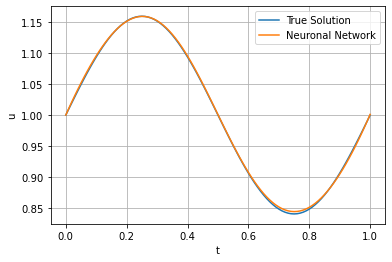

In [3]:
X = torch.from_numpy(np.random.rand(10**5))
y = np.cos(2*np.pi*X) # see eq. 7

X_train, X_val, y_train, y_val = map(torch.tensor, train_test_split(X, y, test_size=0.2, random_state=42))
train_dataloader = DataLoader(TensorDataset(X_train.unsqueeze(-1), y_train.unsqueeze(-1)),
                              batch_size=BATCH_SIZE,
                              pin_memory=True, shuffle=True)
val_dataloader = DataLoader(TensorDataset(X_val.unsqueeze(-1), y_val.unsqueeze(-1)), batch_size=BATCH_SIZE,
                            pin_memory=True, shuffle=True)

model = NNfunc().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9, nesterov=True)
eng = Engine(model, optimizer, device=DEVICE)

best_loss = np.inf
early_stopping_iter = 10
early_stopping_counter = 0

for epoch in range(MAX_EPOCH):
    train_loss = eng.train(data_loader=train_dataloader)
    val_loss = eng.evaluate(data_loader=val_dataloader)
    if epoch == 0 or (epoch+1)%5 == 0:
        print(f"Epoch: {epoch+1},\t Train Loss: {train_loss},\tValidation Loss: {val_loss}")
    if val_loss < best_loss:
        best_loss = val_loss
        early_stopping_counter = 0
        if SAVE_MODEL:
            torch.save(model.state_dict(), f"model.bin")
    else:
        early_stopping_counter += 1
    if early_stopping_counter > early_stopping_iter:
        break

if PLOT:
    X = torch.linspace(0, 1, 101)
    y = np.sin(2 * np.pi * X) / (2 * np.pi) + 1.0 # see eq. 9
    plt.plot(X, y, label='True Solution')
    g = lambda t: 1.0 + t * model(t) # see eq. 5
    plt.plot(X, [g(X_i.reshape(1, 1).to(DEVICE)) for X_i in X], label='Neuronal Network')
    plt.grid(True, which='both')
    plt.legend()
    plt.xlabel('t')
    plt.ylabel('u')

The embedded trial function $g(t)$ is a universal approximator. And due to the Universal Approximation Theorem (UAT) we know that it can approximate our nonlinear function. The UAT implies that a neuronal network, which is sufficiently large, can approximate any continuous function on a bounded domain.
<a href="https://arxiv.org/abs/2004.08867#:~:text=A%20Universal%20Approximation%20Theorem%20of%20Deep%20Neural%20Networks%20for%20Expressing%20Probability%20Distributions,-Yulong%20Lu%2C%20Jianfeng&text=In%20particular%2C%20the%20size%20of,on%20d%20at%20most%20polynomially">[A Universal Approximation Theorem of Deep Neural Networks for Expressing Probability Distributions, Yulong Lu]</a>
In order to approximate these continuous nonlinear functions one could also use different approaches, that satisfy the prerequisite of the UAT. For instance one could use arbitrary polynomials $f(x) = a_0 + a_1 x + a_2 x^2 + \dots$ or a fourier series $f(x) = \frac{a_0}{2} + \sum_k (a_k \cos(kx) + b_k \sin(kx))$ to approximate any continuous function. In the case of a function that is dependent on two dimensions $f(x, y)$ one has to take the tensor product of the UA. Thus, we will receive a higher dimensional UA:
    $$f(x,y) = a_0 + a_1 x + a_2 y + a_3 x y + a_4 x^2 y + a_5 x y^2 + a_6 x^2 y^2 + \dots$$
Since we have to include every combination of terms this kind of approach would result in an exponential growth with $n^d$ coefficients. ($n$ coefficients in each dimension $d$) This kind of growth is the so-called curse of dimensionality. In contrast, the parameters of neuronal networks that approximate a $d$ dimensional function, grow as a polynomial of $d$. This property of polynomial rather than exponential growth enable neuronal networks to surmount the curse of dimensionality.
<a href="https://mitmath.github.io/18337/lecture3/sciml.html">[Introduction to Scientific Machine Learning through Physics-Informed Neural Networks, Chris Rackauckas]</a>.

## Harmonic Oscillator with deformities in the spring
*The following example is very much related to Chris Rackauckas course notes in <a href="https://mitmath.github.io/18337/lecture3/sciml.html">[Introduction to Scientific Machine Learning through Physics-Informed Neural Networks, Chris Rackauckas]</a>.* <br> <br>

In the preceding example the differential equation had all the information that described the physical model. In the following case we assume that we are only aware of a part of the differential equation that describes the physical model. However, this time we have some actual measurements from the real physical system. Thus, our goal is to modify the loss function $L(p)$ of our neuronal network, such that it incorporates the actual measurements and the portion of ODE that we are familiar to.
Suppose we have a spring with some deformities. The entire second order differential equation that describes our physical model would be:
    $$F(x) = m x^{\prime\prime} = -kx + 0.1 \sin(x) \quad \quad (11)$$
We have an undamped harmonic oscillator without externally applied force $F(t) = 0$ and assume a mass of $m = 1$. Hence, the ODE reduces to the following equation:
    $$F(x) = x^{\prime\prime} = -kx + 0.1 \sin(x) \quad \quad (12)$$
The term $0.1 \sin(x)$ specifies the deformities in the spring.   

Suppose we need to identify the force applied on the spring $F(x)$ at each point in space. In the first stage we solely make use of the actual measurements on the physical system. With the limitation that we only know a few points (4 measurements) with information about the position, velocity and force of the spring at equally spaced times $t_i$.
    
![title](images/TF_FM.png)
Hence, we try to predict the expected force of the spring at any location by training a conventional feed forward neuronal network (no physical information embedded).

Epoch: 1,	 Train Loss: 0.04374217614531517
Epoch: 50,	 Train Loss: 0.0013166749849915504
Epoch: 100,	 Train Loss: 0.0005590120563283563
Epoch: 150,	 Train Loss: 0.0002354290772927925
Epoch: 200,	 Train Loss: 9.870142821455374e-05


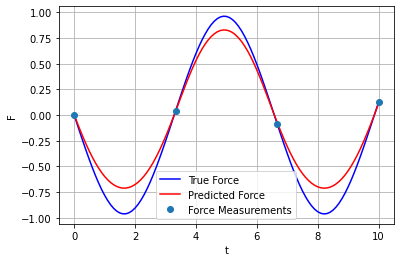

In [4]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from math import floor


# Hyperparameters
LR = 1e-2
MAX_EPOCH = 200
BATCH_SIZE = 4 # batch size is four, since we only have 4 measurements points
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
SAVE_MODEL = False
TEND = 10
PLOT = True


# Solve the second order differential equation numerical
def OdeModel(y, t, k):
    x, v = y
    dydt = [v, -k * x + 0.1 * np.sin(x)]
    return dydt

k = 1.0 # spring stiffness
x0 = [0.0, 1.0] # initial conditions (x: position, v: velocity)
t = np.linspace(0, TEND, 101)
sol = odeint(OdeModel, x0, t, args=(k,)) # numerical solution of the actual differential eq.


# True Force and Force measurements
def force(x, k):
    return -k * x + 0.1 * np.sin(x)

positions_plot = sol[:, 0]
force_plot = force(positions_plot, k) # force at the corresponding position points

t_measurement = np.linspace(0, 10, 4) # measurement timepoints
positions_data = interp1d(t, positions_plot)(t_measurement) # interpoltated position points
force_measurement = interp1d(t, force_plot)(t_measurement) # interpolated true force


# Conventional neuronal network approach wihout any scientific prior
class NNForce(nn.Module):
    def __init__(self):
        super(NNForce, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.Tanh(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

# Wrapper class
class Engine:
    def __init__(self, model, optimizer, device):
        self.model = model
        self.optimizer = optimizer
        self.device = device

    def loss_fn(self, outputs, targets):
        return nn.MSELoss(reduction="mean")(outputs, targets)

    def train(self, data_loader):
        self.model.train()
        final_loss = 0
        for X, y in data_loader:
            X = X.type(torch.float32).to(self.device)
            y = y.type(torch.float32).to(self.device)
            self.optimizer.zero_grad()
            score = self.model(X)
            loss = self.loss_fn(score, y)
            loss.backward()
            self.optimizer.step()
            final_loss += loss.item()
        return final_loss / len(data_loader)
    
X = torch.from_numpy(positions_data)
y = torch.from_numpy(force_measurement)

X_train, y_train = map(torch.tensor, (X, y))

train_dataloader = DataLoader(TensorDataset(X_train.unsqueeze(-1), y_train.unsqueeze(-1)),
                              batch_size=BATCH_SIZE,
                              pin_memory=True, shuffle=True)

model = NNForce().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9, nesterov=True)
eng = Engine(model, optimizer, device=DEVICE)

for epoch in range(MAX_EPOCH):
    train_loss = eng.train(data_loader=train_dataloader)
    if epoch == 0 or (epoch+1)%50 == 0:
        print(f"Epoch: {epoch+1},\t Train Loss: {train_loss}")


t = torch.linspace(0, TEND, 101)
positions_plot = torch.from_numpy(positions_plot).float()

if PLOT:
    plt.plot(t, force_plot, 'b', label='True Force')
    plt.plot(t, [model(x_i.reshape(1, 1).to(DEVICE)) for x_i in positions_plot], 'r', label='Predicted Force')
    plt.plot(t_measurement, force_measurement, 'o', label='Force Measurements')
    plt.legend(loc='best')
    plt.grid(True, which='both')
    plt.xlabel('t')
    plt.ylabel('F')
    plt.show()

It is noticeable that the neuronal network fits the given data at the measurement points, though not the truth force time plot. The reason for the poor fitting of the truth force curve is, that the specified measurement points do not capture all the relevant underlying physics. Presumably one would obtain a better fitting of the truth force development, if the measurement points had been chosen in a manner that covered the underlying characteristics more skillful (measurement points at peak's and valley's). An alternative is to gather more data. However, collecting more data is often very expensive or not even possible in real life applications.

##### Prediction using measurements and physical knowledge (PINNs)
    
Suppose we are not able to obtain more measurement data of the physical system. As aforesaid one approach is to alleviate this condition is to incorporate physical knowledge into the neuronal network. However, in the present case we are not aware of the full underlying differential equation describing our physical model (see eq. 12). Nonetheless, we know Hooke's law, which describes the mechanics of an idealized undamped $d = 0$ spring without externally applied force $F(t) = 0$:
    \begin{equation}
        F(x) = -kx \quad \quad (13)
    \end{equation}

```python
X_ode = 2*torch.rand(100) - 1 # see eq. 13
y_ode = -k*X_ode
```
The following diagram indicates the differences in position and velocity if we compute the numerical solutions for both differential equations ("full" eq. 12 and "simplified" eq. 13) with an ode-solver:
![title](images/simplified.png)
The simplified differential equation drifts near the end, but it is a helpful non-data prior that we can add to enhance the predictions of our neuronal network. Hence, our goal is to use data from the measurements and nudge the prediction of our NN towards Hooke's law. Consequently, we develop a loss function that combines the loss on the measurement data $L_{data}(p)$ and the loss on the simplified ODE $L_{ODE}(p)$:
    \begin{equation}
        L(p) = L_{data}(p) + \lambda \cdot L_{ODE}(p) \quad \quad (14)
    \end{equation}
    
```python
for (X, y), (X_ode, y_ode) in zip(data_loader, data_loader_ode):
    X, X_ode = X.type(torch.float32).to(self.device),
                      X_ode.type(torch.float32).to(self.device)
    y, y_ode = y.type(torch.float32).to(self.device),
                      y_ode.type(torch.float32).to(self.device)
    ...        
    score, score_ode = self.model(X), self.model(X_ode)
    loss = self.loss_fn(score, y, score_ode, y_ode) # see eq. 14
...
def loss_fn(self, outputs, targets, outputs_ode, targets_ode): # see eq. 14
        return nn.MSELoss(reduction="mean")(outputs, targets) 
               + LAMBDA * nn.MSELoss(reduction="mean")(outputs_ode, targets_ode)

```
$\lambda$ is some kind of weighting hyperparameter in order to control the regularization towards the scientific prior.

Epoch: 1,	 Train Loss: 0.07980692386627197
Epoch: 50,	 Train Loss: 0.00022909167455509305
Epoch: 100,	 Train Loss: 0.00021723960526287556
Epoch: 150,	 Train Loss: 0.0002150132495444268
Epoch: 200,	 Train Loss: 0.00021372048649936914


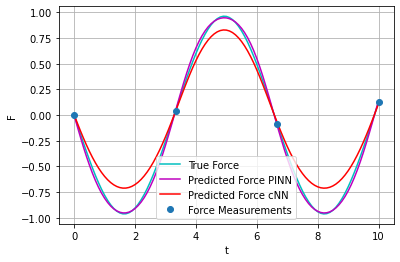

In [5]:
# PINN

# Hyperparameters
LR = 1e-2
MAX_EPOCH = 200
BATCH_SIZE = 4 # batch size is four, since we only have 4 measurements points
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
SAVE_MODEL = False
TEND = 10
PLOT = True

LAMBDA = 0.1 # weighting parameter in the loss function 

# Wrapper class
class EnginePhysicsInformed:
    def __init__(self, model, optimizer, device):
        self.model = model
        self.optimizer = optimizer
        self.device = device

    def loss_fn(self, outputs, targets, outputs_ode, targets_ode): # see eq. 14
        return nn.MSELoss(reduction="mean")(outputs, targets) + LAMBDA * nn.MSELoss(reduction="mean")(outputs_ode, targets_ode)

    def train(self, data_loader, data_loader_ode):
        self.model.train()
        final_loss = 0
        for (X, y), (X_ode, y_ode) in zip(data_loader, data_loader_ode):
            X, X_ode = X.type(torch.float32).to(self.device), X_ode.type(torch.float32).to(self.device)
            y, y_ode = y.type(torch.float32).to(self.device), y_ode.type(torch.float32).to(self.device)
            self.optimizer.zero_grad()
            score, score_ode = self.model(X), self.model(X_ode)
            loss = self.loss_fn(score, y, score_ode, y_ode)
            loss.backward()
            self.optimizer.step()
            final_loss += loss.item()
        return final_loss / len(data_loader)


X = torch.from_numpy(positions_data)
y = torch.from_numpy(force_measurement)

X_train, y_train = map(torch.tensor, (X, y))

train_dataloader = DataLoader(TensorDataset(X_train.unsqueeze(-1), y_train.unsqueeze(-1)),
                              batch_size=BATCH_SIZE,
                              pin_memory=True, shuffle=True, drop_last=True)

X_ode = 2*torch.rand(100) - 1
y_ode = -k*X_ode # see eq. 13

X_ode, y_ode = map(torch.tensor, (X_ode, y_ode))

train_dataloader_ode = DataLoader(TensorDataset(X_ode.unsqueeze(-1), y_ode.unsqueeze(-1)),
                                  batch_size=floor(len(X_ode)/floor(len(X_train)/BATCH_SIZE)),
                                  pin_memory=True, shuffle=True, drop_last=True)


model_pin = NNForce().to(DEVICE)
optimizer = torch.optim.SGD(model_pin.parameters(), lr=LR, momentum=0.9, nesterov=True)
eng_pin = EnginePhysicsInformed(model_pin, optimizer, device=DEVICE)

for epoch in range(MAX_EPOCH):
    train_loss = eng_pin.train(data_loader=train_dataloader, data_loader_ode=train_dataloader_ode)
    if epoch == 0 or (epoch+1)%50 == 0:
        print(f"Epoch: {epoch+1},\t Train Loss: {train_loss}")


t = torch.linspace(0, TEND, 101)
positions_plot = positions_plot.float()
plt.plot(t, force_plot, 'c', label='True Force')
plt.plot(t, [model_pin(x_i.reshape(1, 1).to(DEVICE)) for x_i in positions_plot], 'm', label='Predicted Force PINN')
plt.plot(t, [model(x_i.reshape(1, 1).to(DEVICE)) for x_i in positions_plot], 'r', label='Predicted Force cNN')
plt.plot(t_measurement, force_measurement, 'o', label='Force Measurements')
plt.xlabel('t')
plt.ylabel('F')
plt.legend(loc='best')
plt.grid(True, which='both')
plt.show()

From the upper diagram it is obvious that informing the neuronal network training procedure with prior physical knowledge (PINN) improved the prognosis of the architecture. It should be noted that the acronym <b>cNN</b> in the diagram means conventional neuronal network (<b>not</b> Convolutional Neuronal Network). Moreover, one should note, that in all the previous examples we did not attempt to find optimal configurations or study the influence of various hyperparameters on the accuracy of the method.
<a href="https://arxiv.org/abs/physics/9705023#:~:text=Artificial%20Neural%20Networks%20for%20Solving%20Ordinary%20and%20Partial%20Differential%20Equations,-I.%20E.%20Lagaris%2C%20A&text=We%20present%20a%20method%20to,problems%20using%20artificial%20neural%20networks.&text=Hence%20by%20construction%20the%20boundary,to%20satisfy%20the%20differential%20equation.">[Artificial Neural Networks for Solving Ordinary and Partial Differential Equations, Isaac E. Lagaris]</a>

## Identification of Nonlinear Interactions with Universal Ordinary Differential Equations
*The example in this section is related to section 2.1 of the following paper <a href="https://arxiv.org/abs/2001.04385">[Universal Differential Equations for Scientific Machine Learning]</a>.*
<br> <br>
In this section we support the symbolic regression framework SINDy with a Universal Ordinary Differential Equation (UODE). Thereby we provide a method to reconstruct the unknown underlying terms of our dynamical system in a more data-efficient manner. We demonstrate the approach with the Lokta-Volterra system:
    \begin{equation}
    \begin{aligned}
        \dot{x} = \alpha x - \beta x y\\
        \dot{y} = \gamma x y - \delta y
    \end{aligned} 
    \quad \quad (15)
    \end{equation}
We suppose that we have measurements for the state variables $x(t)$ and $y(t)$ for a short time series $t \in [0, 3]$. Moreover, we assume that we are aware of the birth rate $\alpha = 1.3$ of the prey $x$ and the death rate $\gamma = 1.8$ of the predator $y$. With the given information we introduce a UODE with prior biological knowledge:
    \begin{equation}
    \begin{aligned}
        \dot{x} = \alpha x + U_{\theta, 1}(x, y) \\
        \dot{y} = -\delta y + U_{\theta, 2}(x, y)
    \end{aligned} 
    \quad \quad (16)
    \end{equation}
In this manner we include the prior known information and allow the identification of the unknown interaction among the predators and preys. The true values for the unknown interaction $\mathbf{U}$ are $[-\beta x y, \gamma x y]^T$. The detection of the unknown engagements between the state variables in the UODE, results in the training of an Universal Approximator (UA) $\mathbf{U}_{\theta}: \mathbb{R}^{2} \rightarrow \mathbb{R}^{2}$. The UA is represented as an fully connected neuronal network with 2 input variables, 3 hidden layers with 5 hidden neurons each, a gaussian rbf activation function and 2 outputs:

```python
# Universal Approximator (UA) U: R^2 -> R^2
class UA(nn.Module):
    def __init__(self):
        super(UA, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 5),
            self.rbf(),
            nn.Linear(5, 5),
            self.rbf(),
            nn.Linear(5, 5),
            self.rbf(),
            nn.Linear(5, 2)
        )
    # Gaussian RBF activation function
    class rbf(nn.Module):
        def forward(self, input: torch.Tensor) -> torch.Tensor:
            return torch.exp(-torch.pow(input, 2))

    def forward(self, t, x):
        return self.net(x)    
    
```
The UA is embedded in the UODE (see eq. 16):

```python
# Universal Ordinary Differential Equation (UODE)
class UODE(nn.Module):
    def __init__(self):
        super(UODE, self).__init__()
        self.ua = UA()

    def uode_sys(self, u, x, y):
        u1, u2 = torch.split(u, 1)
        dx_dt = torch.add(torch.mul(alpha, x), u1)
        dy_dt = torch.add(torch.mul(-delta, y), u2)

        return torch.cat([dx_dt, dy_dt])

    def forward(self, t, xy):
        with torch.set_grad_enabled(True):
            self.xy = xy
            x, y = torch.split(xy, 1)
            self.xy = self.ua(None, self.xy)
            self.xy = self.uode_sys(self.xy, x, y)

        return self.xy  
    
```
In the following code section we use the torchdiffeq library to solve the UODE system. The code was modified in a way that we do not have to train the model again. We load the model state dict of the pretrained UODE and predict the time-derivatives of the unknown interaction with the UA.
    
```python
with torch.no_grad():
    # Prediction of the state variables with UODE System
    pred_xy = torchdiffeq.odeint(model, true_xy0, t)
    # Prediction of the derivatives of the unknown part 
    # state variables with the UA (!UA is part of UODE)
    pred_interaction_dot = model.ua(None, pred_xy)
```

=> Loading checkpoint


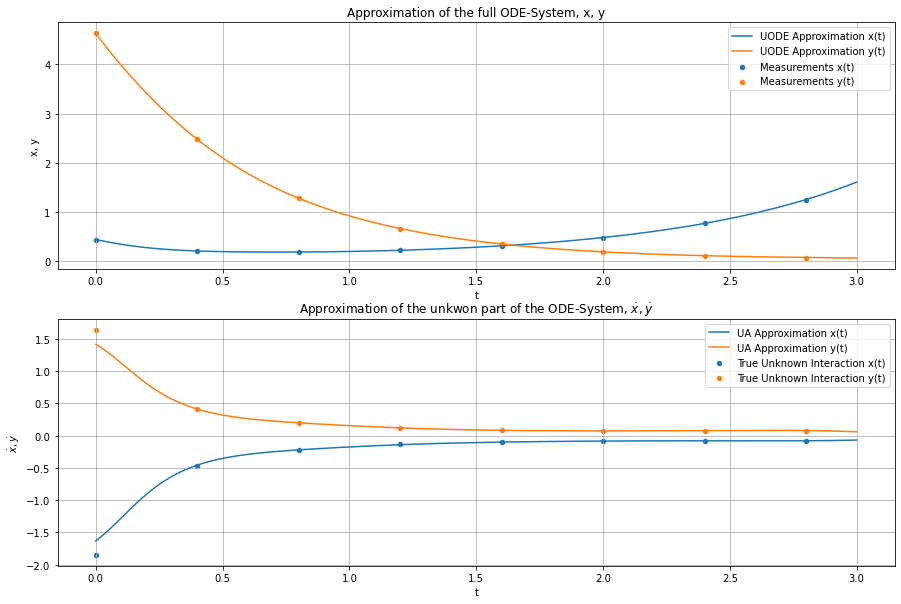

In [6]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import torchdiffeq
import pysindy as ps

# Controls
DEVICE = torch.device("cpu")
LOAD_MODEL = True
SAVE_MODEL = False
PLOT = True
OPTIMIZER = "LBFGS"
LOAD_MODEL_FILE = "trainedmodel/model_statedict.pth.tar"

# Hyperparameters
MAX_EPOCHS = 0
LEARNING_RATE  = 0.01
WEIGHT_DECAY = 0.0
TEND = 3
DT = 0.02

# Parameters
true_xy0 = torch.tensor([0.44249296,4.6280594])
t = torch.linspace(0, TEND, int((TEND-0)/DT + 1))
alpha, beta, gamma, delta = torch.tensor([1.3, 0.9, 0.8, 1.8])

# Universal Approximator (UA) U: R^2 -> R^2
class UA(nn.Module):
    def __init__(self):
        super(UA, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 5),
            self.rbf(),
            nn.Linear(5, 5),
            self.rbf(),
            nn.Linear(5, 5),
            self.rbf(),
            nn.Linear(5, 2)
        )

    # Gaussian RBF activation function
    class rbf(nn.Module):
        def forward(self, input: torch.Tensor) -> torch.Tensor:
            return torch.exp(-torch.pow(input, 2))

    def forward(self, t, x):
        return self.net(x)
    
# Universal Ordinary Differential Equation (UODE)
class UODE(nn.Module):
    def __init__(self):
        super(UODE, self).__init__()
        self.ua = UA()

    def uode_sys(self, u, x, y):
        u1, u2 = torch.split(u, 1)
        dx_dt = torch.add(torch.mul(alpha, x), u1)
        dy_dt = torch.add(torch.mul(-delta, y), u2)

        return torch.cat([dx_dt, dy_dt])

    def forward(self, t, xy):
        with torch.set_grad_enabled(True):
            self.xy = xy
            x, y = torch.split(xy, 1)
            self.xy = self.ua(None, self.xy)
            self.xy = self.uode_sys(self.xy, x, y)

        return self.xy
    
# Full ODE System with unknown interaction
class ODE_Full(nn.Module):
    def forward(self, t, xy):
        x, y = xy
        dx_dt = torch.Tensor([alpha*x - beta*x*y])
        dy_dt = torch.Tensor([-delta*y + gamma*x*y])
        return torch.cat([dx_dt, dy_dt])

# ODE System with only the unknown interaction
class ODE_Part(nn.Module):
    def forward(self, t, xy):
        x, y = xy
        dx_dt = torch.Tensor([- beta*x*y])
        dy_dt = torch.Tensor([gamma*x*y])
        return torch.cat([dx_dt, dy_dt])
    
# Utilities
# Load model and optimizer state_dict
def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

# Save model and optimizer state_dict
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)
    
# Soving the ODE-System, all parameters given
with torch.no_grad():
    # True solution for the state variables
    true_xy = torchdiffeq.odeint(ODE_Full(), true_xy0, t, method='dopri5')

# Define the Universal Ordinary Equation model
model = UODE()
optimizer = torch.optim.LBFGS(model.parameters(), lr=LEARNING_RATE, )
if LOAD_MODEL:
    load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

# Train the model
for itr in range(1, MAX_EPOCHS + 1):
    def closure():
        optimizer.zero_grad()
        pred_xy = torchdiffeq.odeint(model, true_xy0, t)
        loss = torch.sum((pred_xy - true_xy) ** 2)
        print(f"Epoch: {itr}, Loss: {loss}")
        loss.backward()
        return loss
    optimizer.step(closure)
    
# Save model and optimizer state_dict
if SAVE_MODEL:
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    save_checkpoint(checkpoint, filename=LOAD_MODEL_FILE)
    
# deactivate autograd engine, reduces memory usage but not able to backprob, no gradiens saved
with torch.no_grad():
    # Prediction of the state variables with UODE System
    pred_xy = torchdiffeq.odeint(model, true_xy0, t)
    # Prediction of the derivatives of the unknown part 
    # state variables with the UA (!UA is part of UODE)
    pred_interaction_dot = model.ua(None, pred_xy)

true_u1 = torch.mul(-beta, torch.mul(pred_xy[:,0], pred_xy[:,1]))
true_u2 = torch.mul(gamma, torch.mul(pred_xy[:,0], pred_xy[:,1]))
# True solution of the derivatives of the unknown part state variables
true_interaction_dot = torch.transpose(torch.stack([true_u1, true_u2]), 0, 1)

# Soving the unknown part of the ODE-System, all parameters given
with torch.no_grad():
    # True solutiono of the unknown part state variables
    true_interaction = torchdiffeq.odeint(ODE_Part(), true_xy0, t, method='dopri5')
    
if PLOT:
    # index for scatter plot
    idx = np.arange(0, len(t), 20)
    
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))

    axes[0].scatter(t[idx], true_xy[idx, 0], s=20, label="Measurements x(t)")
    axes[0].scatter(t[idx], true_xy[idx, 1], s=20, label="Measurements y(t)")
    axes[0].plot(t, pred_xy[:,0], label="UODE Approximation x(t)")
    axes[0].plot(t, pred_xy[:,1], label="UODE Approximation y(t)")
    axes[0].grid(True, which='both')
    axes[0].set(xlabel='t', ylabel='x, y', title='Approximation of the full ODE-System, x, y')
    axes[0].legend()

    axes[1].scatter(t[idx], true_interaction_dot[idx, 0], s=20, label="True Unknown Interaction x(t)")
    axes[1].scatter(t[idx], true_interaction_dot[idx, 1], s=20, label="True Unknown Interaction y(t)")
    axes[1].plot(t, pred_interaction_dot[:,0], label="UA Approximation x(t)")
    axes[1].plot(t, pred_interaction_dot[:,1], label="UA Approximation y(t)")
    axes[1].grid(True, which='both')
    axes[1].set(xlabel='t', ylabel=r"$\dot x, \dot y$", 
                title='Approximation of the unkwon part of the ODE-System, $\dot x, \dot y$')
    axes[1].legend()

The first chart compares the UODE approximation and some measurements of the state variables of the entire ODE-System within the time interval $t \in [0, 3]$. The latter diagram indicates the differences of the true unknown interactions $[-\beta x y, \gamma x y]^T$ and the predictions of our UA $\mathbf{U}_{\theta}$. In the following code cell we make use of the SINDy algorithm which enables us to identify the underlying mathematical terms of the unknown interactions.<br>    
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<i>SINDy: <b>S</b>parse <b>I</b>dentification of <b>N</b>onlinear <b>Dy</b>namical systems</i><br>
Most physical systems only rely on a few significant terms that define the dynamics. This property makes the governing equations sparse in a high-dimensional nonlinear function space.
SINDy seeks to describe the time derivatives of the given measurements $\mathbf{x}(t) \in \mathbb{R}^n$ in terms of a nonlinear function $\mathbf{f}$:
    \begin{equation}
        \frac{d}{dt}\mathbf{x}(t) = \mathbf{f}(\mathbf{x}(t)) \quad \quad (17)
    \end{equation}
The vector $\mathbf{x}(t) = [x_1(t), x_2(t), \dots, x_n(t)]^T$ represents the state variables of our physical system at a certain time $t$. Whereas the function $\mathbf{f}(\mathbf{x}(t))$ denotes the dynamic constraints of how the system changes with time. As aforesaid the main idea behind SINDy is that the function $\mathbf{f}$ often only contains a few terms. Terefore, $\mathbf{f}$ is sparse in the space of a set of an a priori selected set of basis functions $\mathbf{\Theta}$. If we choose the set of basis functions $\mathbf{\Theta}$ in appropriate manner, $\mathbf{f}$ can be formulated as a linear combination of the monomials $\vartheta_i$ of basis functions $\theta_i$ (e.g. polynomial basis function) where most of the coefficients $\xi_i$ are equal to 0:
    \begin{equation}
        f_i(\mathbf{x}) = \xi_1 \vartheta_1(\mathbf{x}) + \xi_2 \vartheta_2(\mathbf{x}) + \dots + \xi_k \vartheta_k(\mathbf{x}) \quad \quad (18)
    \end{equation}
The data of the measured state variables and the corresponding time derivatives at different times $t_1, t_2, \dots, t_m$ is arranged in the matrixes $\mathbf{X}$ and $\mathbf{\dot{X}}$:
    \begin{equation}
        \mathbf{X} = 
        \begin{bmatrix}
             \mathbf{x}^T(t_1)\\
             \mathbf{x}^T(t_2)\\
             \vdots\\
             \mathbf{x}^T(t_m)
         \end{bmatrix} = 
         \begin{bmatrix}
             x_1(t_1)& x_2(t_1) & \dots & x_n(t_1)\\
             x_1(t_2)& x_2(t_2) & \dots & x_n(t_2)\\
             \vdots  & \vdots   & \ddots & \vdots\\
             x_1(t_m)& x_2(t_m) & \dots & x_n(t_m)
         \end{bmatrix} \quad \quad (19)   
        \\ \\
        \mathbf{\dot{X}} = 
        \begin{bmatrix}
             \mathbf{\dot{x}}^T(t_1)\\
             \mathbf{\dot{x}}^T(t_2)\\
             \vdots\\
             \mathbf{\dot{x}}^T(t_m)
         \end{bmatrix} = 
         \begin{bmatrix}
             \dot{x}_1(t_1)& \dot{x}_2(t_1) & \dots & \dot{x}_n(t_1)\\
             \dot{x}_1(t_2)& \dot{x}_2(t_2) & \dots & \dot{x}_n(t_2)\\
             \vdots  & \vdots   & \ddots & \vdots\\
             \dot{x}_1(t_m)& \dot{x}_2(t_m) & \dots & \dot{x}_n(t_m)
         \end{bmatrix} \quad \quad (20)     
    \end{equation}
The library matrix $\mathbf{\Theta}(\mathbf{X})$ consist of a set of selected basis functions. For instance the library matrix could consist of constant, polynomial or trigonometric terms.
    \begin{equation}      
         \mathbf{\Theta}(\mathbf{X}) = 
         \begin{bmatrix}
             \mid& \mid &  & \mid\\
             \mathbf{\theta}_1(\mathbf{X})& \mathbf{\theta}_2(\mathbf{X}) & \dots & \mathbf{\theta}_l(\mathbf{X})\\
             \mid  & \mid   &  & \mid
         \end{bmatrix} \quad \quad (21) \\
    \mathbf{\theta}_i(\mathbf{X}) = 
         \begin{bmatrix}
             \vartheta_1(t_1)& \vartheta_2(t_1) & \dots & \vartheta_k(t_1)\\
             \vartheta_1(t_2)& \vartheta_2(t_2) & \dots & \vartheta_k(t_2)\\
             \vdots  & \vdots   & \ddots & \vdots\\
         \vartheta_1(t_m)& \vartheta_2(t_m) & \dots & \vartheta_k(t_m)\\
         \end{bmatrix} \quad \quad (22)  
    \end{equation}
Thus, each $\mathbf{\theta}_i$ denotes a candidate function for the right side of equation 17. Since most of the coefficients $\xi_i$ of these nonlinearities in $\mathbf{f}$ are 0, we introduce sparse vectors of coefficients $\mathbf{\Xi} = [\vec{\xi}_1 \vec{\xi}_2 \dots \vec{\xi}_n]$ that define which nonlinearities are active. This leads to the following sparse regression problem:
    \begin{equation}
        \dot{\mathbf{X}} \approx \mathbf{\Theta}(\mathbf{X})\mathbf{\Xi} \quad \quad (23)  
    \end{equation}
The vector $\vec{\xi}_i$ denotes the coefficients for the linear combination of the basis functions (see eq. 18):
    \begin{equation}
        \dot{\mathbf{x}}_k = \mathbf{f}_k(\mathbf{x}) = \mathbf{\Theta}(\mathbf{x}^T) \vec{\xi}_k \quad \quad (24)  
    \end{equation}
<a href="https://www.pnas.org/content/113/15/3932">[Discovering governing equations from data by sparse identification of nonlinear dynamical systems, Steven L. Brunton et al.]</a>
In the following code cell we define the SINDy algorithm with the pysindy library. The main difference in the UODE-enhanced approach to the regular use of the SINDy algorithm is, that we do not have to numerically approximate the derivatives $\dot{\mathbf{X}}$ (e.g. with finite difference methods). In our case we have the UA $\mathbf{U}_\theta(x, y)$ as an estimator of the derivative for the unknown interaction terms. Thus, we perform the sparse regression on the UA  $\mathbf{U}_\theta(x, y)$ to obtain just the equation of the unknown interactions. In our simplified example we only used a 2-dimensional polynomial basis. A more elaborated approach would be possible with the help of scipy's GridSearchCV method.

In [7]:
# Sparse identification of nonlinear dynamics to identify the underlying mathematical
# equation of the unknown interaction

# define the parameters for the model, the prober parameters can be determined
# with e.g. Gridsearch method (GridSearchCV - scipy) 
feature_library  = ps.feature_library.PolynomialLibrary(degree=2)
optimizer  = ps.optimizers.STLSQ(threshold=0.05)
# Define the SINDy Model
model_SINDy = ps.SINDy(
    feature_library=feature_library,
    optimizer=optimizer,
    feature_names=["x", "y"]
)

# Prepare variables for SINDy
pred_interaction_dot = pred_interaction_dot.squeeze().numpy()
t = t.unsqueeze(-1).numpy()
pred_xy = pred_xy.numpy()

# Fit the SINDy model
model_SINDy.fit(pred_xy, t=t, x_dot=pred_interaction_dot)
print("SINDy Predicton - unknown part of the ODE:")
model_SINDy.print()

# Param Grid for Gridsearch Method to identify the optimal parameters for SINDy Algorithm
# model_SINDy = ps.SINDy(t_default=DT)
# param_grid = {
#     "optimizer__threshold": [0.05],
#     "optimizer": [ps.optimizers.STLSQ()],
#     "feature_library": [ps.feature_library.PolynomialLibrary()],
#     "feature_library__degree": [2, 3],
#     "feature_names": [["x", "y"]]
# }
#
# search = GridSearchCV(
#     model_SINDy,
#     param_grid,
#     cv=TimeSeriesSplit(n_splits=10)
# )

# search.fit(pred_xy, t=t, x_dot=pred_interaction_dot)
# print("Best parameters:", search.best_params_)
# model_SINDy = search.best_estimator_
# print("SINDy Predicton - unknown part of the ODE:")
# model_SINDy.print()

SINDy Predicton - unknown part of the ODE:
x' = -0.885 x y
y' = 0.781 x y


The SINDy algorithm yields to an approximation of the $\beta$ and $\gamma$ value of $-0.885$ and $0.781$ and a 2-dimensional polynomial of $x y$ for the unknown interactions:
    \begin{equation}
    \begin{aligned}
        \dot{x}_{recovered} = 1.3 x + U_{\theta, 1}(x, y) = 1.3 x -0.885 x y \\
        \dot{y}_{recovered} = -1.8 y + U_{\theta, 2}(x, y) = -1.8 y + 0.781  x y
    \end{aligned} 
    \quad \quad (25)
    \end{equation}
    
```python
# ODE-System with the SINDy recovered dynamics implemented
def SINDy_recovered_dynamics(xy, t):
    xy = np.expand_dims(xy, axis=0)
    x, y = xy[0]
    
    # SINDy recoverd dynamics
    u1, u2 = model_SINDy.predict(xy)[0]
    return [alpha*x + u1,
            -delta*y + u2]
```
The true values for $\beta$ and $\gamma$ are $-0.9$ and $0.8$:
    \begin{equation}
    \begin{aligned}
        \dot{x}_{true} = 1.3 x -0.9 x y \\
        \dot{y}_{true} = -1.8 y + 0.8  x y
    \end{aligned} 
    \quad \quad (26)
    \end{equation}

In the following code cell we compare the Lokta-Volterra equation approximation with UODE-enhanced SINDy and the true state variables.

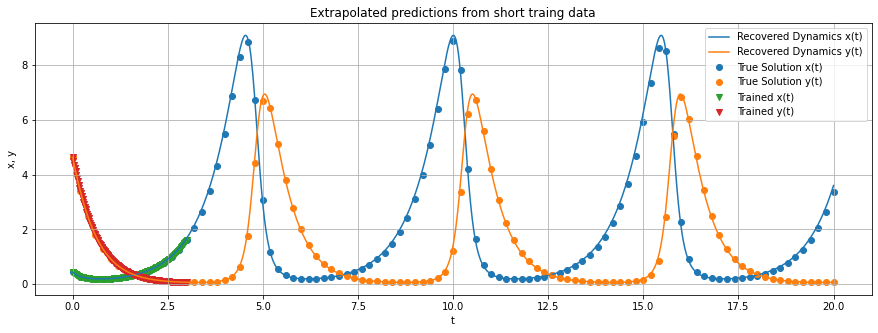

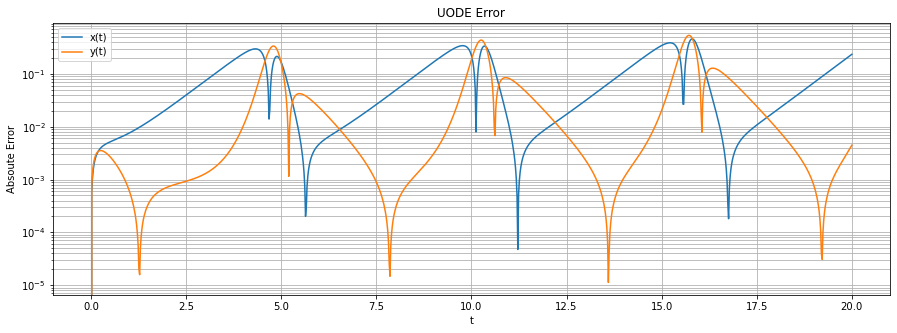

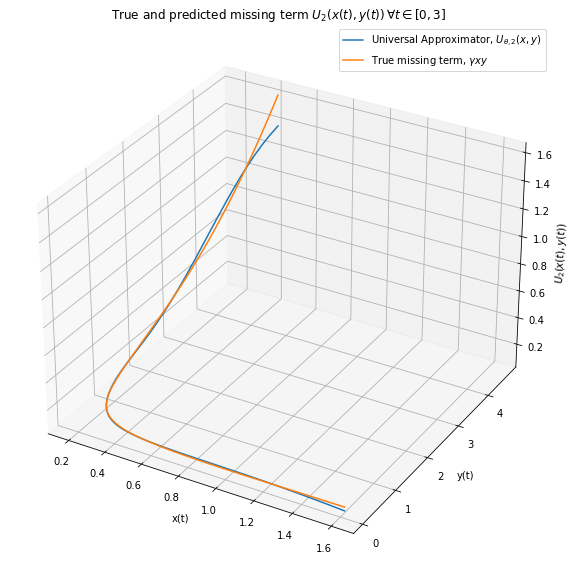

In [8]:
# ODE-System with the SINDy recovered dynamics implemented
def SINDy_recovered_dynamics(xy, t):
    xy = np.expand_dims(xy, axis=0)
    x, y = xy[0]
    
    # SINDy recoverd dynamics
    u1, u2 = model_SINDy.predict(xy)[0]
    return [alpha*x + u1,
            -delta*y + u2]

# untrained t-values
t_ = torch.linspace(0, 20, int((20-0)/DT + 1))
# True solution to untrained t-values
true_xy_ = torchdiffeq.odeint(ODE_Full(), true_xy0, t_, method='dopri5')
# SINDy recovered predictions to untrained t-values
recovered_xy_ = integrate.odeint(SINDy_recovered_dynamics, true_xy0, t_)

if PLOT:
    # index for scatter plot
    idx = np.arange(0, len(t_), 10)
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    ax.scatter(t_[idx], true_xy_[idx,0], label="True Solution x(t)")
    ax.scatter(t_[idx], true_xy_[idx,1], label="True Solution y(t)")
    ax.plot(t_, recovered_xy_[:,0], label="Recovered Dynamics x(t)")
    ax.plot(t_, recovered_xy_[:,1], label="Recovered Dynamics y(t)")
    ax.scatter(t, true_xy[:,0], marker='v', label="Trained x(t)")
    ax.scatter(t, true_xy[:,1], marker='v', label="Trained y(t)")
    ax.set(xlabel="t", ylabel="x, y", title='Extrapolated predictions from short traing data')
    ax.grid(True, which='both')
    ax.legend()
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    ax.plot(t_,np.abs(true_xy_[:,0] - recovered_xy_[:,0]), label="x(t)")
    ax.plot(t_,np.abs(true_xy_[:,1] - recovered_xy_[:,1]), label="y(t)")
    ax.set(yscale='log', xlabel='t', ylabel='Absoute Error', title='UODE Error')
    ax.grid(True, which='both')
    ax.legend()
    
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')
    ax.plot(pred_xy[:,0], pred_xy[:,1],pred_interaction_dot[:,1], label=r"Universal Approximator, $U_{\theta, 2}(x, y)$")
    ax.plot(pred_xy[:,0], pred_xy[:,1],true_interaction_dot[:,1], label=r"True missing term, $\gamma x y$")
    ax.set(yscale='linear', xlabel='x(t)', ylabel='y(t)', zlabel=r'$U_{2}(x(t), y(t))$', title=r'True and predicted missing term $U_{2}(x(t), y(t)) \, \forall t \in [0, 3]$')
    ax.grid(True, which='both')
    ax.legend()

In the first chart we compare the extrapolation of the knowledge-enhanced SINDy approximation with the true state variables $x(t)$ and $y(t)$. The green and red triangles show some datapoints which were used to fit the UODE. The blue and orange dots show the true solution $t \in [0, 20]$ of the ODE beyond the measurement data we used for training $t \in [0, 3]$. The blue and orange lines display the extrapolated solution of the UODE-enhanced SINDy recovered equation. It is central to note that even though the measured data $t \in [0, 3]$, which we used to fit the UODE-enhanced SINDy approach, did not include an entire period of the cyclic solution, the resulting approximation was able to extrapolate quite accurately.
The second diagram displays the absolute error in the UODE-enhanced SINDy approach against the true state variables $x(t)$ and $y(t)$. We observe that the error increases for higher values of $t$.
The final graph illustrates the values of the unknown interaction $U_{2}(x, y)$ evaluated with the UA $U_{\theta, 2}(x, y)$ and the true values $\gamma x y$.<br> <br>
Further there are far more fields of application for using the UDE framework:<br>
<a href="https://mitmath.github.io/18337/lecture15/diffeq_machine_learning">[Mixing Differential Equations and Neural Networks for Physics-Informed Learning, Chris Rackauckas]</a>
<ul>
    <li>Extensions to other Differential Equations</li>
    <ul>
      <li>Universal Stochastic Differential Equations (USDEs)</li>
      <li>Universal Differential-Algebraic Equations (UDAEs)</li>
      <li>Universal Delay Differential Equations (UDDEs)</li>
      <li>Universal Boundary Value Problems (UBVPs)</li>
      <li>Universal Partial Differential Equations (UPDEs)</li>
      <li>etc.</li>
    </ul>
    <li>Deep BSDE Methods for High Dimensional Partial Differential Equations</li>
    <ul>
      <li>Nonlinear Black-Scholes</li>
      <li>Stochastic Optimal Control</li>
      <li>etc.</li>
    </ul>
    <li>Surrogate Acceleration Methods</li>
    <li>etc.</li>
</ul>
The methods used in the scope of the previous studies incorporated data into our models using point estimates. Though in real-life applications, data has uncertainty and noise. Consequently, we should extend our modeling methods in order to incorporate probabilistic estimates:<br>
<a href="https://mitmath.github.io/18337/lecture16/probabilistic_programming">[From Optimization to Probabilistic Programming, Chris Rackauckas]</a>
<ul>
    <li>Bayesian Estimation with Point Estimates (point estimates for the most probable parameters</li>
    <li>Bayesian Estimation of Posterior Distributions</li>
    <ul>
      <li>Sampling Based Approach (Monte Carlo, Metropolis Hastings Algorithm, Hamiltonian Monte Carlo)</li>
    <li>Variational Inference (Automatic Differentiation Variational Inference (ADVI))</li>
    </ul>
</ul>
Further the question arises how the output of the model generally alters with a change in the input. For this we need an understanding of the global sensitivity of the model. This enables us, for example to identify if there are any variables which do not have an actual effect on the output. We could use this approach to reduce our model by dropping of the corresponding terms.<br>
<a href="https://mitmath.github.io/18337/lecture17/global_sensitivity">[Global Sensitivity Analysis, Chris Rackauckas]</a>
<ul>
  <li>The Morris One-At-A-Time (OAT) Method</li>
  <li>Sobol's Method (ANOVA)</li>
  <li>Fourier Amplitude Sensitivity Sampling (FAST) and eFAST</li>
  <li>etc.</li>
</ul>  
Moreover, we must note that our neural differential equations can lead to inexact results due to truncation, numerical and measurement errors. Thus, we want to identify the types and sources of uncertainties. The subject of this matter is known as Uncertainty Quantification (UQ).<br> <br>
In the scope of this study we used PyTorch and the corresponding available libraries to solve problems in the field of scientific machine learning. For more elaborated studies in the area of scientific machine learning, it is recommended to use the open source software SciML based on the programming language Julia. 
<a href="https://sciml.ai/">[SciML Scientific Machine Learning Software]</a>